In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from bs4 import BeautifulSoup
import random
import string
from collections import Counter
import jieba.posseg as pseg




C:\Users\cxy\AppData\Roaming\Python\Python311\site-packages\bs4\css.py:8: UserWarning: The soupsieve package is not installed. CSS selectors cannot be used.
  warnings.warn(


# 数据来源：  
1.Wang, Y., Yang, W., Ma, F., Xu, J., Zhong, B., Deng, Q., & Gao, J. (2020). Weak Supervision for Fake News Detection via Reinforcement Learning. Proceedings of the AAAI Conference on Artificial Intelligence, 34(01), 516-523.

后面分析发现都是来自微信公众号平台

网页：

# 数据统计

In [2]:
"""文档读取csv文件"""
data = pd.read_csv('./train/train.csv')
data.head()

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
0,0,朝阳实拍,范冰冰出轨被偷拍？这才是真相！,http://mp.weixin.qq.com/s?__biz=MzI1NzIzNDkxNQ...,http://mmbiz.qpic.cn/mmbiz_jpg/XUUcJo9yhYRlbzt...,发布误导信息,1
1,1,文刊,马容竟然去了非诚匆扰，一出场24盏灯全灭，孟爷爷都笑了,http://mp.weixin.qq.com/s?__biz=MzUxODE2MDMwMQ...,https://mmbiz.qlogo.cn/mmbiz_jpg/X3Cv4sIxE7Bib...,标题与内容不符##骗点击##欺骗阅读者。,1
2,2,掌上武冈,突发：武冈西站木材市场燃起大火，浓烟滚滚火势巨大，现场...,http://mp.weixin.qq.com/s?__biz=MzAwMjM0NzMxOA...,https://mmbiz.qlogo.cn/mmbiz_jpg/fnLwjhfLVGZQK...,报道内容不实，描述事实也不食,0
3,3,时事内幕爆料,辞职交警!爆`出贪 污惊人内幕！99%车主都不知道！速看,http://mp.weixin.qq.com/s?__biz=MzU3NjIzNTI5OA...,https://mmbiz.qlogo.cn/mmbiz_jpg/hYnJtOcFjEhV0...,谣言！##不实,0
4,4,大参考,美国两块让国人汗颜的告示牌，告诉我们离文明有多远,http://mp.weixin.qq.com/s?__biz=MzA5MDE4NTY4Mw...,http://mmbiz.qpic.cn/mmbiz_jpg/T0OtTToYoIR77vL...,虚假宣传##以偏概全,0


In [3]:
"""数据信息"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     10587 non-null  int64 
 1   Ofiicial Account Name  10585 non-null  object
 2   Title                  10587 non-null  object
 3   News Url               10587 non-null  object
 4   Image Url              10587 non-null  object
 5   Report Content         10587 non-null  object
 6   label                  10587 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 579.1+ KB


In [4]:
"""读取单个html"""
# with open('./train/html/0.html', encoding='utf-8') as f:
#     html = f.read()
#     print(html)

'读取单个html'

In [5]:
"""真假新闻个数, 虚假新闻占比"""
data['label'].value_counts(), f"{data['label'].value_counts()[1]/data['label'].value_counts()[0]:.6f}"

(label
 0    7844
 1    2743
 Name: count, dtype: int64,
 '0.349694')

In [6]:
"""是否都是来自微信公众号"""
data.count(), data['News Url'].str.contains('mp.weixin.qq.com').value_counts()


(id                       10587
 Ofiicial Account Name    10585
 Title                    10587
 News Url                 10587
 Image Url                10587
 Report Content           10587
 label                    10587
 dtype: int64,
 News Url
 True    10587
 Name: count, dtype: int64)

# html分析

In [7]:
"""html文件读取"""

html_list = []
for i in tqdm(range(data.shape[0])):
    with open("./train/html/{}.html".format(i), encoding='utf-8') as f:
        html = f.read()
        html_list.append(html)
html_list = pd.Series(html_list)
html_list.head()

100%|██████████| 10587/10587 [00:14<00:00, 751.74it/s]


0    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
1    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
2    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
3    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
4    <!DOCTYPE html>\n<html class="">\n  <head>\n  ...
dtype: object

In [8]:
"""html文件长度"""
html_lengths = list(html_list.apply(lambda x: len(x)))
html_lengths_pd = pd.DataFrame(html_lengths, columns=['html_lenths'])
print("info:", html_lengths_pd.info())
print("describe:\n", html_lengths_pd.describe())
print("众数及其数量:\n", html_lengths_pd.mode())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   html_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
          html_lenths
count   10587.000000
mean   178249.129876
std    252367.988048
min     17690.000000
25%     27555.000000
50%     27876.000000
75%    572228.500000
max    944942.000000
众数及其数量:
    html_lenths
0        27555


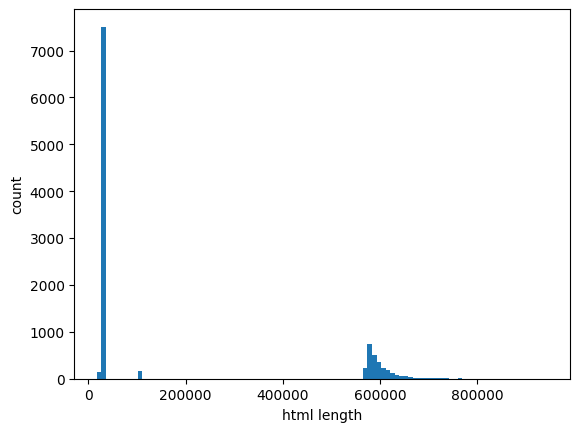

In [9]:
"""html文件长度分布图"""
plt.hist(html_lengths, bins=100)
plt.xlabel('html length')
plt.ylabel('count')
plt.show()


In [10]:
html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       10568, 10569, 10571, 10573, 10575, 10576, 10577, 10581, 10582, 10585],
      dtype='int64', length=7834)

In [11]:
"""筛选html文件长度小于200000的,并得到序号"""
shortlen_html_pd = pd.DataFrame(html_lengths_pd[html_lengths_pd['html_lenths'] < 200000],
                                index = html_lengths_pd[html_lengths_pd['html_lenths'] < 200000].index)
print(shortlen_html_pd.describe())
print(shortlen_html_pd.value_counts())

         html_lenths
count    7834.000000
mean    29196.990809
std     11133.430110
min     17690.000000
25%     27555.000000
50%     27555.000000
75%     28016.000000
max    102502.000000
html_lenths
27555          4054
27673           581
28016           471
28053           362
27251           352
               ... 
24312             1
28089             1
29679             1
29519             1
27340             1
Name: count, Length: 120, dtype: int64


# text分析

In [12]:
"""通过utf-8编码将html文件中的文字和汉字符号部分提取出来"""
number = [n for n in string.digits]
chinese_symbol = ['。', '，', '！', '？', '；', '：', '“', '”', '‘', '’', '（', '）', '《', '》', '、', '…', '—', '【', '】']
text_list = []
for html in tqdm(html_list):
    soup = BeautifulSoup(html)
    chinese_text = ''.join(soup.stripped_strings)
    chinese_text = [char for char in chinese_text if '\u4e00' <= char <= '\u9fff' or char in chinese_symbol or char in number]
    text_list.append(''.join(chinese_text))


100%|██████████| 10587/10587 [01:11<00:00, 147.08it/s]


In [13]:
"""浏览"""
def showText(text_list):
    for i in range(100):
        index = random.randint(0, len(text_list))
        print(index, '\t', text_list[index])
showText(text_list)

3652 	 22岁成为镇长，25岁就当市委书记。26岁竟然省委书记女儿该账号已冻结第1章被架空的镇长7月流火，太阳炙烤着大地。天气闷的让人发慌，稍微动一动，便满身是汗。关山镇。镇长办公室内。柳擎宇静静的坐在镇长的位子上，心中思绪万千。今天，是他军转干之后，正式上任镇长的第二天。他是前天下午在景林县县委组织部的一个排名最末的副部长李有福的陪同下来到关山镇的。当天晚上在镇里领导陪同下吃了晚饭之后，李有福便连夜赶回县里了。此刻，是上午10点钟，柳擎宇已经在办公室里面坐了2个多小时了，然而，在过去的一天一夜外加2个小时的时间内，镇里面没有一个人来他这里汇报工作，更没有任何文件和资料传递到他这里。他好像被整个关山镇给遗忘了一般，又有像是透明人，被人完全忽略掉了。柳擎宇眉头紧锁，他在思考着。他心中清楚，这肯定是镇委书记石振强的小动作。因为他发现，自从自己被李有福送到镇里上任之后，这个镇委书记就开始对自己另眼相看了，或者说是下马威也不为过。前天接风宴上，除了比自己早一个月上任的镇委副书记秦睿婕碰杯喝酒以外，其他人的态度就变得“暧昧”多了，不是互相对饮，就是与书记石振强觥杯交筹，而且每喝一杯，石振强都会朝他若有若无地笑上一笑，似是在示意自己在镇里的威望……柳擎宇静静的坐在椅子上，大脑飞快的转动着。然而，他想破大天也想不出来为什么镇委书记石振强会带头针对自己。按照常理来说，自己刚刚到任，不可能和他之间产生任何利益冲突和其他矛盾的。但是偏偏石振强上来就给了自己一个下马威，他到底有何用意？是何居心？就在柳擎宇琢磨石振强的用意时，石振强也在聊着他。在石振强的办公室内，常务副镇长、镇党委委员胡光远坐在石振强的对面，脸上露出一丝幸灾乐祸的神色，看向石振强说道：“石书记，我真没有想到，这一次新来的镇长居然是一个才刚刚22岁的毛头小子，我很纳闷，他到底有什么背景啊，居然22岁就当上了镇长，这也太夸张了吧。该不会这小子是个官二代或者富二代吧？否则的话怎么可能这么年轻就当上镇长呢？”石振强的脸色十分平静，他知道，胡光远对于柳擎宇这个突然空降下来的毛头小子抢了本来属于他的镇长宝座十分不爽，总是想要给对方上眼药，虽然他这两天已经给了柳擎宇一个下马威了，但是对于柳擎宇这个突然空降下来的毛头小子，他却并没有放松警惕，但也不会做得太过分。因为他曾经试图查阅柳擎宇的简历，但却发现，除了一份特别简单的简历之外，以

In [14]:
"""数据清洗，将无用的语句、信息删除"""

dirty_words = ["：，。视频小程序赞，轻点两下取消赞在看，轻点两下取消在看",
               "分享留言收藏",
               "向上滑动看下一个知道了微信扫一扫使用小程序取消允许取消允许分析",
               "预览时标签不可点微信扫一扫关注该公众号继续滑动看下一个轻触阅读"
               ]
for index, test in enumerate(text_list):
    for dirty_word in dirty_words:
        text_list[index] = text_list[index].replace(dirty_word, '')
showText(text_list)


6746 	 该内容已被发布者删除微信公众平台运营中心
8416 	 该内容已被发布者删除微信公众平台运营中心
4820 	 男子急忙拿3万给岳母手术，抢救一半发现老人竟然在家…建外14号听朋友说自己岳母被车撞了黑龙江省佳木斯市的赵先生赶紧上医院交了手术费之后却发现救的这人不认识！这到底是咋回事呢？8月7日，黑龙江佳木斯市发生了一起交通事故，一辆车将一位路人撞倒。佳木斯市交警支队事故大队民警栗瑞南介绍说，等我们赶到现场的时候，发现行人（伤者）躺在道路上，伤者被120送往医院。与此同时，赵先生听朋友说自己的岳母被撞伤了，人在医院。“我哥们到我那大排档告诉我说老丈母娘被撞了，我跟我媳妇到达医院，当时押了一万块钱，一直抢救到晚上8点多，一共花了3万多。”这一晚，小两口在抢救室外是心急如焚。“（医生）一会告诉我抢救过来了，一会又不行了，冰火两重天啊！”赵先生说，我媳妇都昏倒两回了，两个人扶着，吃着救心丸。我家所有亲戚都在那哭啊，终老衣服都买回来了。然而等到交了钱后，晚上医生把伤者的耳环从手术间拿出来，赵先生发现不是岳母的物品，才知道伤者是陌生人。“（医生）把耳环送出来才知道，那不是我老丈母娘。因为我老丈母娘没有耳环。”赵先生说，我就叫人回家去看丈母娘有没有在家，一进屋，老丈母娘在家呢！原来，不幸被撞的是一位捡废品的老太太，而赵先生的岳母常在附近捡废品，他哥们就搞错了。赵先生的妻子也表示，这是闹了个乌龙吧，给他们年轻人也上了深刻的一课，没事多陪陪母亲。伤者家属称，这3万元会马上归还给赵先生。来源：扬子晚报往期新闻回顾【视频】祸从天降！上海一商铺招牌脱落砸中路人，3死6伤50个孩子测试，42个被“拐走”！警惕人贩子新型骗术！杭州开往北京的40高铁遭彩钢板撞击！致多趟列车晚点，有乘客晕倒两六旬中国游客肯尼亚湖边游玩，遭河马袭击1死1伤更多精彩请猛戳右边二维码了解不一样的北京北京电台官方订阅号原文建外14号
6881 	 该内容已被发布者删除微信公众平台运营中心
3692 	 此账号已被屏蔽内容无法查看接相关投诉，此账号涉嫌违反《互联网用户公众账号信息服务管理规定》，查看详细内容
9810 	 该内容已被发布者删除微信公众平台运营中心
8405 	 该内容已被发布者删除微信公众平台运营中心
4545 	 此内容因违规无法查看由用户投诉并经平台审核，涉及色情、低俗及性暗示信息，或挑逗

In [15]:
"""保存test_list"""
text_path = "./train/text"
if not os.path.exists(text_path):
    os.makedirs(text_path)
for i, text in tqdm(enumerate(text_list)):
    with open(text_path + f'/{i}.txt', 'w', encoding='utf-8') as f:
        f.write(text + '\n')

10587it [00:06, 1675.00it/s]


In [16]:
"""被删除的文章的数量"""

dirty_key_words = ['此内容因违规无法查看', '该内容已被发布者删除', '此账号已被屏蔽内容无法查看',
                   '此账号已自主注销', '原账号迁移时未将文章素材同步至新账号']
dirty_id = [i for i, x in enumerate(text_list) for del_key_word in dirty_key_words if del_key_word in x or x == '']
right_id = [i for i in range(data.shape[0]) if i not in dirty_id]
print(len(dirty_id)+len(right_id))
del_count = len(dirty_id)
print(del_count, f"{del_count/len(text_list):.6f}")

11155
8303 0.784264


In [17]:
"""查看没有被删除的文章"""
right_text = [text_list[i] for i in right_id]
showText(right_text)

2094 	 第523期我们为什么说，这种是传销组织？！原创新媒体工作室北流检察近日，有一批“法律资深”人士对我院针对“传销”案例发布的普法文章“异常愤慨”，组织大量“水军”在我院微信公众号留言刷屏，并无端猜测我院及市公安局对案件定性存在问题，大肆辱骂我院司法办案人员。在此，我院向广大群众进一步揭示，为什么说“深圳双创帮扶农商贸易有限公司”是传销组织。1深圳双创帮扶农商贸易实业发展有限公司到底是什么公司？通过网上查找该公司的一些相关资料，就发现了这个标题为“《中国双创联盟工作委员会》等三大国家级平台成立”的信息，发现该公司三个打着国家级平台：1中国双创联盟工作委员会2国家商品积分交易中心3国家存量资产交易平台然而，该公司在工商管理总局的企业库查询情况是？？？所谓的“中国双创联盟工作委员会”，“国家存量资产交易平台”这些东西都是蹭着“大众创业，万众创新”，“模式”等名义做的资金盘。正规双创帮扶企业的查询情况应当是这个样子！一个连个备案都不敢备的公司，还打着国家级平台的名义：忽悠，接着忽悠！盈利模式：天上掉馅饼？2只是把钱放到这个平台什么都不用做，2个月变15积分，再过两个月变22500积分，再过两个月33750，50625，75938，1年就可以变成113906。可以购物可以提现，但事实上积分只能换成百分之25的人民币，而且购物也是需要消耗积分的同时还要花人民币！由此可推理出，投了1万元进去最起码得等到第8个月才能提现因为前6个月提现是百分百亏的，第8个月提现能兑换成人民币12656那这样就能赚2000多块钱。这样算下来确实比放银行划算多了，但请大家冷静的分析一下，如果放满1年提现就能拿到28476元，这投资1万元回报率是280多。这么大的回报率？银行里的基金理财项目才12的回报率，还需要承担风险。不都说是国家平台么？两者怎么差距这么大？银行还怎么活？从这点上看，平台赚取利润的方式就非常可疑了。而且他们发展下线投钱进去还能有提成拿，根据《禁止传销条例》（国务院令第444号）第二条的规定：“传销是指组织者或者经营者发展人员，通过对被发展人员以其直接或者间接发展的人员数量或者销售业绩为依据计算和给付报酬，或者要求被发展人员以交纳一定费用为条件取得加入资格等方式牟取非法利益，扰乱经济秩序，影响社会稳定的行为。”本质上是“庞氏骗局”，即以后来者的钱发前面人的收益。目前还衍生出

In [18]:
"""查看被删除的文章为虚假新闻的概率"""
del_fake_count = sum(1 for value in data['label'][dirty_id] if value == 1)
print(del_fake_count, f"{del_fake_count/del_count:.6f}")


2536 0.305432


In [19]:
"""查看未被删除的文章为虚假新闻的概率"""
right_count = sum(1 for value in data['label'][right_id] if value == 1)
print(right_count, f"{right_count/len(right_id):.6f}")

327 0.114656


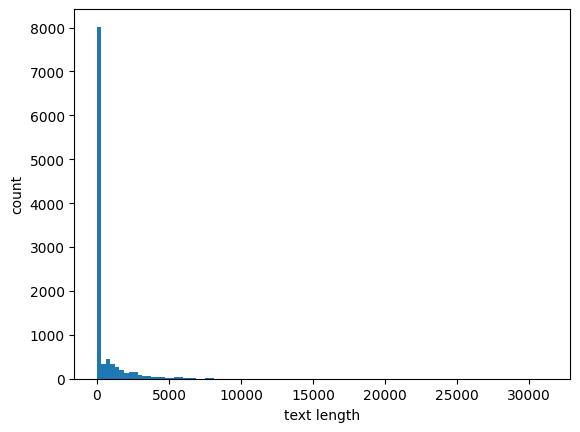

In [20]:
"""text文件长度分布图"""
plt.hist([len(x) for x in text_list], bins=100)
plt.xlabel('text length')
plt.ylabel('count')
plt.show()


In [21]:
"""text文件长度"""
text_lenths = [len(x) for x in text_list]
text_lenths_pd = pd.DataFrame(text_lenths, columns=['text_lenths'])
print("info:", text_lenths_pd.info())
print("describe:\n", text_lenths_pd.describe())
print("众数:\n", text_lenths_pd.mode())
print(text_lenths_pd.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10587 entries, 0 to 10586
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   text_lenths  10587 non-null  int64
dtypes: int64(1)
memory usage: 82.8 KB
info: None
describe:
         text_lenths
count  10587.000000
mean     525.010673
std     1341.227423
min        0.000000
25%       20.000000
50%       52.000000
75%      196.500000
max    31288.000000
众数:
    text_lenths
0           20
text_lenths
20             4059
52              708
59              551
56              361
15              352
               ... 
2034              1
2038              1
690               1
2046              1
31288             1
Name: count, Length: 1586, dtype: int64


# 特征提取

剔除被删除的文章丢弃，得到可用于训练的数据集，也就是剩下的right_id所对应的文章rifht_text，进行特征提取。

In [22]:
for i in range(10):
    print(right_text[i])

一年后退役！韦德作出最后决定终老热火！原创柚子柚子说球有时候有些消息就是这么悄无声息在我们所有人都还沉浸在甜瓜签约正要为休赛期的这个节点松一口气联盟最后一个悬念也紧接着揭晓了韦德在今天正式宣布他的未来决定可能是正在办理离职手续应接不暇这次的重磅消息轮到了爆料“韦德将与热火队续约一年继续征战，并且在下赛季结束之后选择退役！”韦大爷的最后一个赛季！韦德的动态也基本验证了这个消息他刚刚在社交媒体上发布了照片晒出自己与热火队友们训练的合照“和兄弟们一起训练！老流氓，没有牙的，黄金手臂以及我认识的最酷的人！”而詹姆斯约翰逊的配文则是：是“我们”永远不会是“他们”！这消息来得太快柚子还没能反应我们很高兴能够看见韦德重返热火再次身披3号战袍为迈阿密打拼相信这是韦德一直以来都想要的结局留在迈阿密是他从来不曾动摇的决定我们都知道浙江队曾经开出过3年2500万美元的天价希望韦德能够选择前往中国打球虽然浙江也表示自己明白这机会很小但是就是这么一点机会他们也要试试而韦德在作出最终决定之前就委婉的拒绝了来自中国的邀请他明确地对媒体表示自己还没有决定但是如果自己选择继续征战赛场的话一定会是身披热火的战袍没有别的可能同时他也解释了自己为什么拒绝在接受迈阿密当地媒体采访时他表示“我在中国有自己的品牌，如果我去那里打球会是个非常好的决定，但是家庭因素成为了我放弃的关键原因我儿子正在上高中，我想陪伴他，我要给他所有一切可能的支持现在我要为了家庭留在迈阿密不论我是否选择退役。”韦德的回归固然是一件好事每一位他的球迷都渴望再次目睹那个3号闪电侠继续在赛场驰骋只可惜这是闪电侠的最后一个赛季了这一个赛季的打拼和较量过后我们称呼韦德的方式将不是热火队员而是“迈阿密之魂，热火名宿韦德”忆往昔峥嵘岁月单枪匹马直捣黄龙闪电侠带给我们无数的经典瞬间他将自己书写进了名人堂之中也把自己刻进了球迷们的心里当年霸气劈扣瓦莱乔如今依旧高呼“这是我的马！”我们只希望这一切都不是真的柚子只想看见这条新闻的前半段但是如果这是千真万切的结局改不了的我们只能更加珍惜韦德在的最后一个赛季！——如果你喜欢我的文章可以关注微信公众号柚子说球预览时标签不可点阅读原文微信扫一扫关注该公众号继续滑动看下一个轻触阅读原文柚子说球
著名主持人朱军被爆性骚扰实习女生！泗州文艺昨天，新浪微博百万粉丝大罗昌平发微博，内容为某匿名网友发长文控诉央视名主持朱军对自

In [23]:
right_data = data.iloc[right_id]
# 保存
with open("./train/right_data.csv", 'w', encoding='utf-8') as f:
    right_data.to_csv(f, index=False)

# 保存label为1的数据
with open("./train/right_data_fake.csv", 'w', encoding='utf-8') as f:
    right_data[right_data['label'] == 1].to_csv(f, index=False)
# 保存label为0的数据
with open("./train/right_data_real.csv", 'w', encoding='utf-8') as f:
    right_data[right_data['label'] == 0].to_csv(f, index=False)

right_data.head(10)
    

,id,Ofiicial Account Name,Title,News Url,Image Url,Report Content,label
10,10,柚子说球,一年后退役！韦德作出最后决定终老热火！,http://mp.weixin.qq.com/s?__biz=MzIxOTI5NTk5MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/6sMnWYZVWaR85gd...,未经证实散步韦德退役谣言,0
11,11,泗县城市网,著名主持人朱军被爆性骚扰实习女生！,http://mp.weixin.qq.com/s?__biz=MzIxMzAyNzU5NQ...,http://mmbiz.qpic.cn/mmbiz_jpg/qtGJibt7gqfPS4V...,未经证实,1
16,16,女神生活街,郑恺新恋情曝光，将和他携手退出跑男？网友：迪丽热巴暗讽看真相,http://mp.weixin.qq.com/s?__biz=MzIyODUzNjk5MA...,http://mmbiz.qpic.cn/mmbiz_jpg/ayhEAOFHVILicQD...,毫无根据，言语混乱,1
17,17,房里房外,台前县吴坝镇黄河滩区迁建成果初现，街亮了，家新了，腰包鼓了，昔日穷滩区，今日新城镇，国家扶贫...,http://mp.weixin.qq.com/s?__biz=MzA4NjQ1OTY0OA...,http://mmbiz.qpic.cn/mmbiz_jpg/92LsX90lExTEwuO...,我们不是滩区，为什么拆我们的房子。老百姓越来越穷，搬不起。##这个发表文章记者认识他受贿，他...,0
18,18,海门大神,@所有海门人！海门各乡镇微信群开通了！现邀请您来一起噶闹忙咯！！！,http://mp.weixin.qq.com/s?__biz=MzU5MzA0NTQzNw...,http://mmbiz.qpic.cn/mmbiz_jpg/ZibsiaicPwOia7i...,各群都是无聊退应该取缔,0
20,20,参考消息,德媒：被中国打中“七寸” 美国农民对贸易争端失去耐心,http://mp.weixin.qq.com/s?__biz=MjM5MzA0MTg2MA...,http://mmbiz.qpic.cn/mmbiz_jpg/F1hLEK71icuAQkk...,你没有你吹牛逼那么强大,0
22,22,爱临汾,忻州中西医结合医院造假大量骗取医保资金,http://mp.weixin.qq.com/s?__biz=MzU0MTcyMjg4MQ...,http://mmbiz.qpic.cn/mmbiz_jpg/gypEaBqfcibXQKw...,不实信息##不实信息,0
23,23,科技犬,卓伟爆料！某女星同侍父子俩，网友脑洞大开，上演名侦探柯南！,http://mp.weixin.qq.com/s?__biz=MzIwNDMyNTk0Ng...,http://mmbiz.qpic.cn/mmbiz_jpg/M4RkZsDvOoGyCJ7...,标题与内容严重不符,1
28,28,嘿星期八,别在危险的边缘试探噢,http://mp.weixin.qq.com/s?__biz=MzUzMjk0MzQyOA...,http://mmbiz.qpic.cn/mmbiz_jpg/IrQdFP8BsWUlNmV...,文中说潮州交通很乱，这点本地人不承认,0
31,31,潍坊论坛,定了！潍坊划入“青岛圈”！,http://mp.weixin.qq.com/s?__biz=MjM5MDA0MzA0Nw...,http://mmbiz.qpic.cn/mmbiz_jpg/b3GzIor9icsO0Tu...,谣言吧,0


In [24]:
"""文本长度 length"""
text_length = pd.Series([text_lenths[i] for i in right_id])
text_length
"""标题长度 title_length"""
title_length = pd.Series([len(data['Title'][i]) for i in right_id])
title_length

0       19
1       17
2       30
3       62
4       33
        ..
2847     9
2848    25
2849    30
2850    25
2851    25
Length: 2852, dtype: int64

In [25]:
"""引号、感叹号、问号引用比率 quote_symbol_rate strong_emotion_symbol_rate"""
symbol_count = []
for text in right_text:
    symbol_count.append(sum(1 for char in text if char in chinese_symbol))
symbol_count = pd.Series(symbol_count)

quote_symbol_count = []
for text in right_text:
    quote_symbol_count.append(sum(1 for char in text if char == '“' or char == '”'))
quote_symbol_count = pd.Series(quote_symbol_count)

strong_emotion_symbol_count = []
for text in right_text:
    strong_emotion_symbol_count.append(sum(1 for char in text if char == '！' or char == '？'))
strong_emotion_symbol_count = pd.Series(strong_emotion_symbol_count)

quote_symbol_rate = quote_symbol_count / symbol_count
strong_emotion_symbol_rate = strong_emotion_symbol_count / symbol_count  

# 归一化
quote_symbol_rate = (quote_symbol_rate - quote_symbol_rate.min()) / (quote_symbol_rate.max() - quote_symbol_rate.min())
strong_emotion_symbol_rate = (strong_emotion_symbol_rate - strong_emotion_symbol_rate.min()) / (strong_emotion_symbol_rate.max() - strong_emotion_symbol_rate.min())

print(quote_symbol_rate.head())
print(strong_emotion_symbol_rate.head())

0    0.496296
1    0.000000
2    0.145969
3    0.000000
4    0.000000
dtype: float64
0    0.257143
1    0.086957
2    0.264706
3    0.010309
4    0.500000
dtype: float64


In [26]:
"""来源包含娱乐、八卦、搞笑"""
source_from_entertainment = []
for i in right_id:
    if "娱乐" in data['Ofiicial Account Name'][i] or "八卦" in data[
        'Ofiicial Account Name'][i] or "搞笑" in data['Ofiicial Account Name'][i]:
        source_from_entertainment.append(1)
    else:
        source_from_entertainment.append(0)
source_from_entertainment = pd.Series(source_from_entertainment)
source_from_entertainment

0       0
1       0
2       0
3       0
4       0
       ..
2847    0
2848    0
2849    0
2850    0
2851    0
Length: 2852, dtype: int64

In [27]:
"""标签包含人名"""
title_contains_person = []
for i in right_id:
    words = pseg.cut(data['Title'][i])
    count = 0
    for word, flag in words:
        if flag == 'nr':
            count += 1
    title_contains_person.append(count)

title_contains_person = pd.Series(title_contains_person)
# 归一化
title_contains_person = (title_contains_person - title_contains_person.min()) / (title_contains_person.max() - title_contains_person.min())
title_contains_person

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\cxy\AppData\Local\Temp\jieba.cache
Loading model cost 0.549 seconds.
Prefix dict has been built successfully.


0       0.2
1       0.2
2       0.2
3       0.2
4       0.0
       ... 
2847    0.0
2848    0.4
2849    0.0
2850    0.0
2851    0.2
Length: 2852, dtype: float64

In [28]:
"""特征整合"""
my_train = pd.concat([pd.Series(right_id), text_length, title_length, quote_symbol_rate, strong_emotion_symbol_rate, 
                      source_from_entertainment, title_contains_person], axis=1)
my_train.columns = ['id', 'text_length', 'title_length', 'quote_symbol_rate', 'strong_emotion_symbol_rate', 
                    'source_from_entertainment', 'title_contains_person']
my_train.head()

,id,text_length,title_length,quote_symbol_rate,strong_emotion_symbol_rate,source_from_entertainment,title_contains_person
0,10,937,19,0.496296,0.257143,0,0.2
1,11,235,17,0.000000,0.086957,0,0.2
2,16,904,30,0.145969,0.264706,0,0.2
3,17,2204,62,0.000000,0.010309,0,0.2
4,18,378,33,0.000000,0.500000,0,0.0


In [29]:
"""保存"""
my_train.to_csv("./train/my_train.csv", index=False)